In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from data.dataset import COWCDataset
from model.loss import RegClsLoss
import glob
import torch
import torchvision

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

In [3]:
file_list = []
path_train = '/home/kruglov/projects/siod/datasets/cowc/{}/train/*'
path_test = '/home/kruglov/projects/siod/datasets/cowc/{}/test/*'

In [8]:
for ds in ['Selwyn_LINZ','Columbus_AFRL','Potsdam_ISPRS']:
    file_list = file_list + glob.glob(path_train.format(ds)) + glob.glob(path_test.format(ds))
print('Datasets have {} images in total.'.format(len(file_list)))

Datasets have 85366 images in total.


In [9]:
batch_size = 4

In [10]:
dataset = COWCDataset(file_list, transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size= batch_size, shuffle= True)

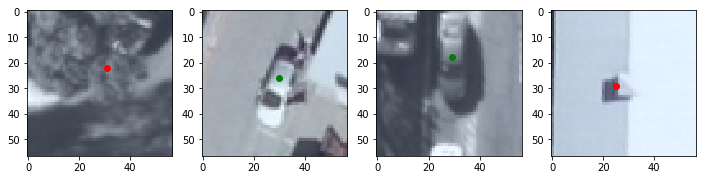

In [14]:
# Sample images from datasets
# positive examples marked with green labels

inputs, labels = iter(dataloader).next()
coords = labels.data.numpy() * 10 + 28
plt.figure(figsize= (12,3))
for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    mark = 'go' if labels[i][2] == 1 else 'ro'
    plt.imshow(np.clip(np.transpose(inputs[i], (1,2,0)) * 0.22 + 0.45, 0, 1))
    plt.plot(coords[i][0], coords[i][1], mark);